*all codes have been executed, don't run any! results are already displayed*

### a0: TESTING, OUTPUT COMPARISON

cequ=0, self interaction energy expected to be 0

In [2]:
import numpy as np
import time

def initialize_wave_function(n1, step, alpha):
    """
    Initialize the wave function arrays.
    
    Parameters:
    n1 (int): Number of integration steps in the r-grid
    step (float): Integration step size in r-space
    alpha (float): Starting parameter for the harmonic oscillator function
    
    Returns:
    xr (ndarray): Radial grid points
    frev (ndarray): Initial wave function values
    freo (ndarray): Copy of initial wave function for iteration
    """
    alpha2 = alpha ** 2
    cvar = 2.0 * np.sqrt(alpha) ** 3 / np.sqrt(np.sqrt(np.pi))
    xr = step * np.arange(n1)  # Radial grid points
    xr2 = xr ** 2
    frev = cvar * xr * np.exp(-0.5 * alpha2 * xr2)  # Initial wave function
    freo = np.copy(frev)  # Copy of the initial wave function for iteration
    return xr, frev, freo

def convergence(n1, step, time_step, iter, cequ, freo, xr):
    """
    Perform the iterative convergence process to update the wave function.
    
    Parameters:
    n1 (int): Number of integration steps in the r-grid
    step (float): Integration step size in r-space
    time_step (float): Time step for the iterative convergence process
    iter (int): Number of iterations for the convergence process
    cequ (float): Interaction parameter
    freo (ndarray): Initial wave function
    xr (ndarray): Radial grid points
    
    Returns:
    freo (ndarray): Converged wave function
    xmu (ndarray): Chemical potential at each grid point
    ene0_values (list): List of energy values at each iteration
    """
    fren = np.zeros(n1)  # Array to store the updated wave function
    xmu = np.zeros(n1)   # Array to store the chemical potential
    ene0_values = []  # List to store energy values at each iteration
    
    for it in range(iter):
        xnorm = 0.0
        ene0 = 0.0
        fred = (np.roll(freo, -1) + np.roll(freo, 1) - 2.0 * freo) / (step ** 2)
        fred[-1] = (freo[-2] - 2.0 * freo[-1]) / (step ** 2)  # Boundary condition
        xr2 = xr ** 2
        
        for i in range(1, n1):
            if freo[i] == 0 or xr[i] == 0:
                xmu[i] = 0.0
            else:
                ene0 -= freo[i] * fred[i] * 0.5
                ene0 += 0.5 * xr2[i] * freo[i] ** 2
                ene0 += 0.5 * cequ * xr2[i] * (freo[i] / xr[i]) ** 4
                xmu[i] = -0.5 * fred[i] / freo[i] + 0.5 * xr2[i] + cequ * (freo[i] / xr[i]) ** 2
            
            fren[i] = freo[i] - time_step * xmu[i] * freo[i]
            xnorm += fren[i] ** 2
        
        xnorm = np.sqrt(xnorm * step)
        ene0 *= step
        ene0_values.append(ene0)
        freo = fren / xnorm
        
        # Print iteration number every 10,000 iterations
        if it % 10000 == 0:
            print(f"Iteration {it} completed.")
    
    return freo, xmu, ene0_values

def calculate_results(n1, step, cequ, freo, xr, xmu, as3n):
    """
    Calculate and return various physical quantities based on the wave function.
    
    Parameters:
    n1 (int): Number of integration steps in the r-grid
    step (float): Integration step size in r-space
    cequ (float): Interaction parameter
    freo (ndarray): Converged wave function
    xr (ndarray): Radial grid points
    xmu (ndarray): Chemical potential at each grid point
    as3n (float): Scaled interaction parameter
    
    Returns:
    radious (float): Radius of the wave function
    radious2 (float): Square of the radius
    xkin (float): Kinetic energy
    pot (float): Total potential energy
    potho (float): Harmonic potential energy
    potself (float): Self-interaction potential energy
    chem (float): Chemical potential
    xnormden (float): Normalized density
    u (ndarray): Potential energy at each grid point
    den (ndarray): Density at each grid point
    """
    fred = (np.roll(freo, -1) + np.roll(freo, 1) - 2.0 * freo) / (step ** 2)
    fred[-1] = (freo[-2] - 2.0 * freo[-1]) / (step ** 2)
    radious = np.sum(xr[1:] ** 2 * freo[1:] ** 2)
    xkin = np.sum(freo[1:] * fred[1:])
    potho = np.sum(xr[1:] ** 2 * freo[1:] ** 2)
    potself = np.sum(xr[1:] ** 2 * (freo[1:] / xr[1:]) ** 4)
    chem = np.sum(xmu[1:] * freo[1:] ** 2)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        u = np.where(xr != 0, 0.5 * xr ** 2 + cequ * (freo / xr) ** 2, 0)
        den = np.where(xr != 0, (freo / xr) ** 2, 0)
    
    xnormden = np.sum(den[1:] * xr[1:] ** 2)
    xaver = np.sum(freo[1:] ** 2 * as3n * den[1:])
    radious2 = radious * step
    radious = np.sqrt(radious * step)
    xaver *= step
    chem *= step
    xkin = -xkin * step * 0.5
    potho = 0.5 * potho * step
    potself = potself * step * cequ * 0.5
    pot = potself + potho
    xnormden *= step

    return radious, radious2, xkin, pot, potho, potself, chem, xnormden, u, den


def main():

    #input data
    
    a0 = 0.0043    # Scattering length in harmonic oscillator units
    n1 = 700     # Number of integration steps in the r-grid
    step = 0.015  # Integration step size in r-space
    aa = 1000000   # Number of atoms
    time_step = 0.00005  # Time step for the iterative convergence process
    alpha = 0.3 # Starting parameter for the harmonic oscillator function
    iter = 70000    # Number of iterations for the convergence process

    cequ = a0 * aa
    as3n = aa * a0 ** 3
    cequ = 0  # Set cequ to 0
    
    # Initialize wave function    
    start_time = time.time()
    xr, frev, freo = initialize_wave_function(n1, step, alpha)
    
    # Perform convergence    
    freo, xmu, ene0_values = convergence(n1, step, time_step, iter, cequ, freo, xr)
    
    # Calculate results    
    radious, radious2, xkin, pot, potho, potself, chem, xnormden, u, den = calculate_results(n1, step, cequ, freo, xr, xmu, as3n)
    
    # Output results 
    print ("")
    print(f"Energy = {ene0_values[-1]}, Average chemical = {chem}, Kinetic Energy = {xkin}, Potential = {pot}, Harmonic Potential = {potho}, Self-Interaction Potential = {potself}")


    end_time = time.time()
    print(f"Total computation time: {end_time - start_time} seconds")

if __name__ == "__main__":
    main()

Iteration 0 completed.
Iteration 10000 completed.
Iteration 20000 completed.
Iteration 30000 completed.
Iteration 40000 completed.
Iteration 50000 completed.
Iteration 60000 completed.

Energy = 1.4999665803922508, Average chemical = 1.4999665800447375, Kinetic Energy = 0.7488594272777901, Potential = 0.751107152766917, Harmonic Potential = 0.751107152766917, Self-Interaction Potential = 0.0
Total computation time: 272.7970266342163 seconds


-----------------------------------------------------------------------------------------------------------------------------

### a: ENERGY COMPARISON FOR N=100,1000,10000,100000,1000000

In [3]:
# main modified for nonzero cequ, variable N
def main():


    # Input parameters
    a0 = 0.00433
    n1 = 700
    step = 0.015
    aa_values = [100,1000, 10000, 100000, 1000000] # list of N values
    time_step = 0.00005
    alpha = 0.3
    iter = 70000

    for aa in aa_values:
        # nonzero cequ
        cequ = a0 * aa 
        as3n = aa * a0 ** 3


        start_time = time.time()
        xr, frev, freo = initialize_wave_function(n1, step, alpha)


        freo, xmu, ene0_values = convergence(n1, step, time_step, iter, cequ, freo, xr)


        radious, radious2, xkin, pot, potho, potself, chem, xnormden, u, den = calculate_results(n1, step, cequ, freo, xr, xmu, as3n)

        # Output results
        print ("")  
        print("N=",aa)
        print(f"Energy = {ene0_values[-1]}, Average chemical = {chem}, Kinetic Energy = {xkin}, Potential = {pot}, Harmonic Potential = {potho}, Self-Interaction Potential = {potself}")
        print(f"Radius = {radious}, Radius^2 = {radious2}")

    
        end_time = time.time()
        print(f"Total computation time: {end_time - start_time} seconds")

if __name__ == "__main__":
    main()

Iteration 0 completed.
Iteration 10000 completed.
Iteration 20000 completed.
Iteration 30000 completed.
Iteration 40000 completed.
Iteration 50000 completed.
Iteration 60000 completed.

N= 100
Energy = 1.6519423354928504, Average chemical = 1.7874004864074218, Kinetic Energy = 0.6560869661487242, Potential = 0.9958553692628458, Harmonic Potential = 0.860397204615937, Self-Interaction Potential = 0.13545816464690877
Radius = 1.3117905355779458, Radius^2 = 1.720794409231874
Total computation time: 251.8462462425232 seconds
Iteration 0 completed.
Iteration 10000 completed.
Iteration 20000 completed.
Iteration 30000 completed.
Iteration 40000 completed.
Iteration 50000 completed.
Iteration 60000 completed.

N= 1000
Energy = 2.4246704245758615, Average chemical = 3.0444878455300897, Kinetic Energy = 0.4374871267334693, Potential = 1.9871832978410722, Harmonic Potential = 1.367365870997023, Self-Interaction Potential = 0.6198174268440492
Radius = 1.6537024345371345, Radius^2 = 2.734731741994

Expected output for N = 1000000:

     * ener 0.30120E+02   average chemical= 0.42119E+02
     * kin-ener= 0.61239E-01     total-pot=  0.30059E+02
     * potho=  0.1806E+02       potint =  0.1200E+02
     * radious =  0.6010E+01      radious2 =  0.3611948E+02

-----------------------------------------------------------------------------------------------------------------------

### b: ENERGY COMPARISON FOR N=100,1000,10000,100000,1000000. Thomas-Fermi Approach

In [5]:
def convergence(n1, step, time_step, iter, cequ, freo, xr):

    fren = np.zeros(n1)  
    xmu = np.zeros(n1)   
    ene0_values = []  
    
    for it in range(iter):
        xnorm = 0.0
        ene0 = 0.0
        fred = np.zeros(n1)  # Neutralizing the Laplacian term
        xr2 = xr ** 2
        
        for i in range(1, n1):
            if freo[i] == 0 or xr[i] == 0:
                xmu[i] = 0.0
            else:
                ene0 += 0.5 * xr2[i] * freo[i] ** 2
                ene0 += 0.5 * cequ * xr2[i] * (freo[i] / xr[i]) ** 4
                xmu[i] = 0.5 * xr2[i] + cequ * (freo[i] / xr[i]) ** 2
            
            fren[i] = freo[i] - time_step * xmu[i] * freo[i]
            xnorm += fren[i] ** 2
        
        xnorm = np.sqrt(xnorm * step)
        ene0 *= step
        ene0_values.append(ene0)
        freo = fren / xnorm
        
        if it % 10000 == 0:
            print(f"Iteration {it} completed.")
    
    return freo, xmu, ene0_values

def calculate_results(n1, step, cequ, freo, xr, xmu, as3n):

    fred = np.zeros(n1)  # Neutralizing the Laplacian term
    radious = np.sum(xr[1:] ** 2 * freo[1:] ** 2)
    xkin = np.sum(freo[1:] * fred[1:])  
    potho = np.sum(xr[1:] ** 2 * freo[1:] ** 2)
    potself = np.sum(xr[1:] ** 2 * (freo[1:] / xr[1:]) ** 4)
    chem = np.sum(xmu[1:] * freo[1:] ** 2)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        u = np.where(xr != 0, 0.5 * xr ** 2 + cequ * (freo / xr) ** 2, 0)
        den = np.where(xr != 0, (freo / xr) ** 2, 0)
    
    xnormden = np.sum(den[1:] * xr[1:] ** 2)
    xaver = np.sum(freo[1:] ** 2 * as3n * den[1:])
    radious2 = radious * step
    radious = np.sqrt(radious * step)
    xaver *= step
    chem *= step
    potho = 0.5 * potho * step
    potself = potself * step * cequ * 0.5
    pot = potself + potho
    xnormden *= step

    return radious, radious2, xkin, pot, potho, potself, chem, xnormden, u, den

if __name__ == "__main__":
    main()


Iteration 0 completed.
Iteration 10000 completed.
Iteration 20000 completed.
Iteration 30000 completed.
Iteration 40000 completed.
Iteration 50000 completed.
Iteration 60000 completed.

N= 100
Energy = 0.7647095221187479, Average chemical = 1.0377256301591387, Kinetic Energy = 0.0, Potential = 0.7647091691716312, Harmonic Potential = 0.4916920602939911, Self-Interaction Potential = 0.2730171088776402
Radius = 0.9916572596355971, Radius^2 = 0.9833841205879822
Iteration 0 completed.
Iteration 10000 completed.
Iteration 20000 completed.
Iteration 30000 completed.
Iteration 40000 completed.
Iteration 50000 completed.
Iteration 60000 completed.

N= 1000
Energy = 1.8983770307254801, Average chemical = 2.6405084192079293, Kinetic Energy = 0.0, Potential = 1.8983769486370605, Harmonic Potential = 1.1562451056152405, Self-Interaction Potential = 0.74213184302182
Radius = 1.5206874140435571, Radius^2 = 2.312490211230481
Iteration 0 completed.
Iteration 10000 completed.
Iteration 20000 completed.

--------------------------------------------------------------------------------------------------------------------------------

### c: DENSITY PROFILE PLOT. GP VS THOMAS-FERMI APPROACH

Iteration 0 completed.
Iteration 10000 completed.
Iteration 20000 completed.
Iteration 30000 completed.
Iteration 40000 completed.
Iteration 50000 completed.
Iteration 60000 completed.

GP Results for N = 100
Energy = 1.6519423354928504, Average chemical = 1.7874004864074218, Kinetic Energy = 0.6560869661487242, Potential = 0.9958553692628458, Harmonic Potential = 0.860397204615937, Self-Interaction Potential = 0.13545816464690877
Radius = 1.3117905355779458, Radius^2 = 1.720794409231874
Total computation time for GP: 250.36775946617126 seconds


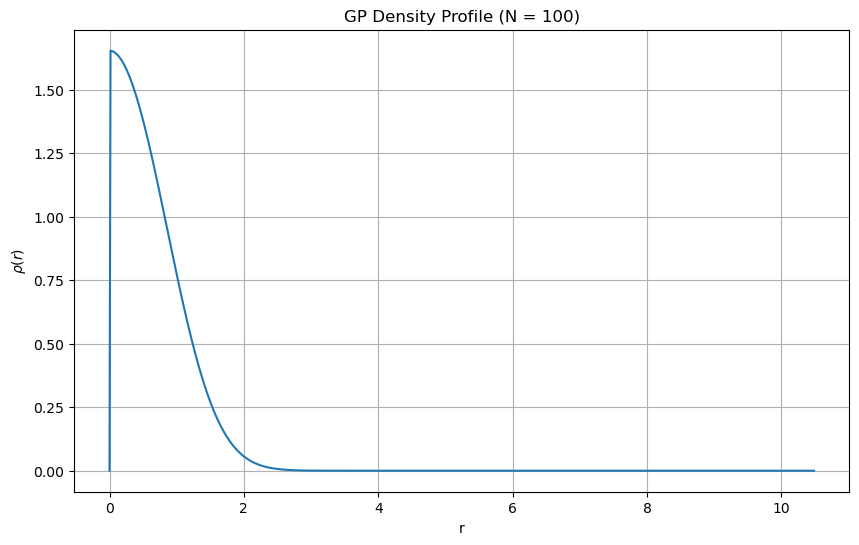

Iteration 0 completed.
Iteration 10000 completed.
Iteration 20000 completed.
Iteration 30000 completed.
Iteration 40000 completed.
Iteration 50000 completed.
Iteration 60000 completed.
Total computation time for TF: 197.16541004180908 seconds


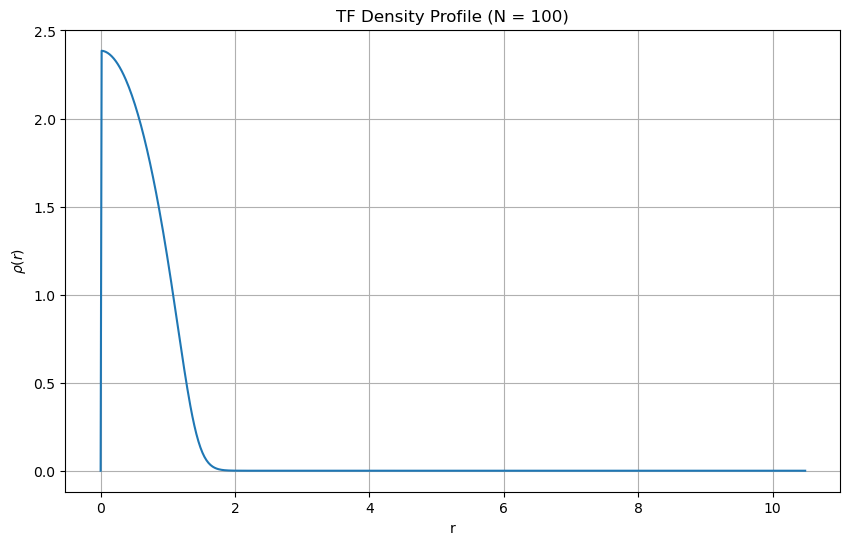

Iteration 0 completed.
Iteration 10000 completed.
Iteration 20000 completed.
Iteration 30000 completed.
Iteration 40000 completed.
Iteration 50000 completed.
Iteration 60000 completed.

GP Results for N = 1000
Energy = 2.4246704245758615, Average chemical = 3.0444878455300897, Kinetic Energy = 0.4374871267334693, Potential = 1.9871832978410722, Harmonic Potential = 1.367365870997023, Self-Interaction Potential = 0.6198174268440492
Radius = 1.6537024345371345, Radius^2 = 2.734731741994046
Total computation time for GP: 253.0620973110199 seconds


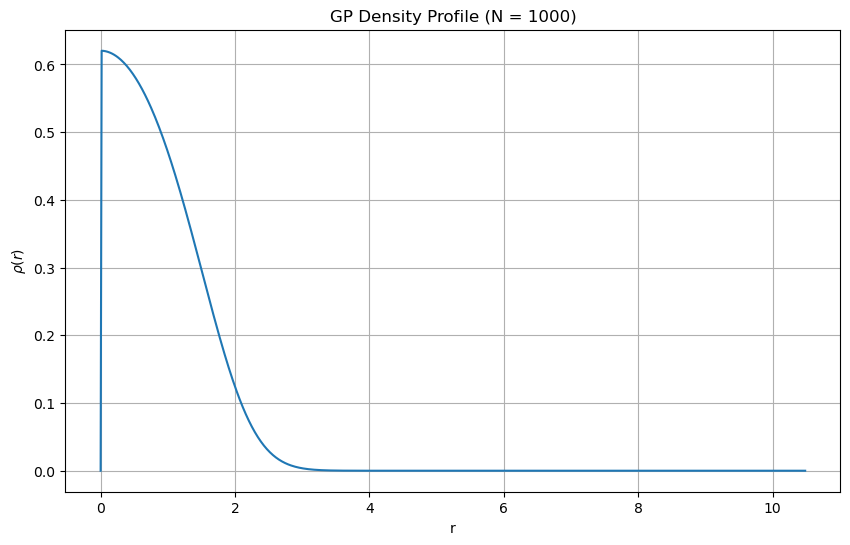

Iteration 0 completed.
Iteration 10000 completed.
Iteration 20000 completed.
Iteration 30000 completed.
Iteration 40000 completed.
Iteration 50000 completed.
Iteration 60000 completed.
Total computation time for TF: 201.0906856060028 seconds


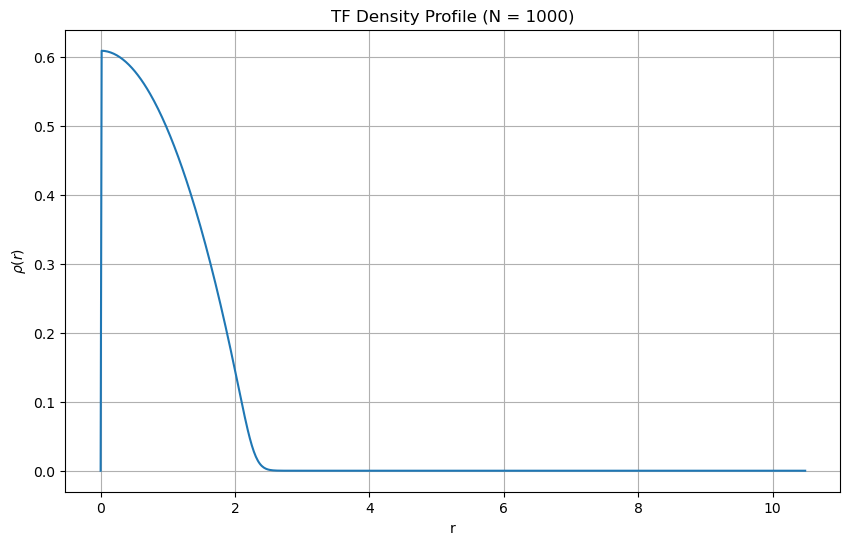

Iteration 0 completed.
Iteration 10000 completed.
Iteration 20000 completed.
Iteration 30000 completed.
Iteration 40000 completed.
Iteration 50000 completed.
Iteration 60000 completed.

GP Results for N = 100000
Energy = 12.103949905268191, Average chemical = 16.84659357096685, Kinetic Energy = 0.12367139605986896, Potential = 11.980278509208393, Harmonic Potential = 7.2376348434913655, Self-Interaction Potential = 4.742643665717027
Radius = 3.8046379179867738, Radius^2 = 14.475269686982731
Total computation time for GP: 246.8649880886078 seconds


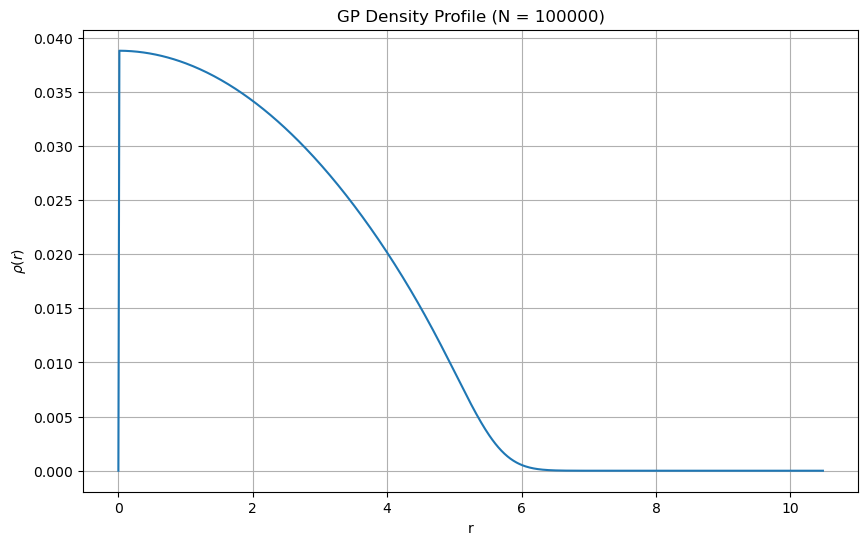

Iteration 0 completed.
Iteration 10000 completed.
Iteration 20000 completed.
Iteration 30000 completed.
Iteration 40000 completed.
Iteration 50000 completed.
Iteration 60000 completed.
Total computation time for TF: 192.5215916633606 seconds


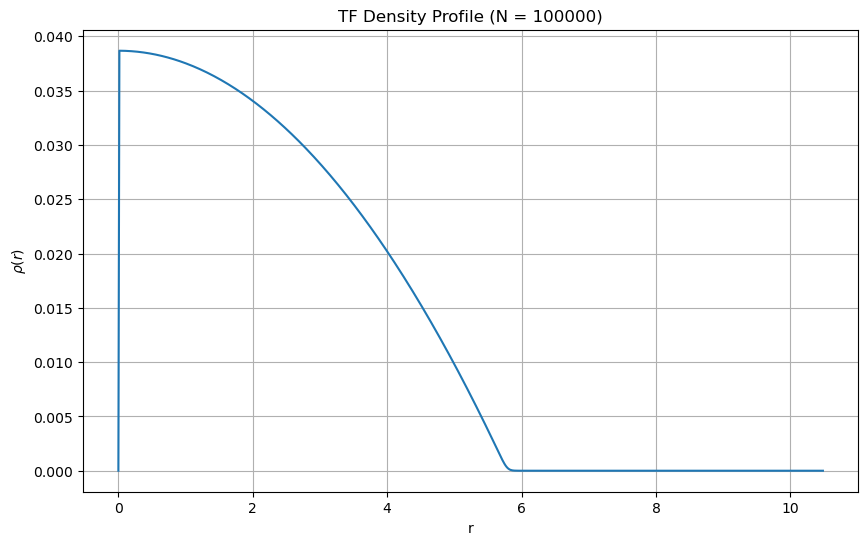

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time

def initialize_wave_function(n1, step, alpha):
    alpha2 = alpha ** 2
    cvar = 2.0 * np.sqrt(alpha) ** 3 / np.sqrt(np.sqrt(np.pi))
    xr = step * np.arange(n1)  
    xr2 = xr ** 2
    frev = cvar * xr * np.exp(-0.5 * alpha2 * xr2)  
    freo = np.copy(frev) 
    return xr, frev, freo

def convergence(n1, step, time_step, iter, cequ, freo, xr):
    fren = np.zeros(n1)  
    xmu = np.zeros(n1)  
    ene0_values = []  
    
    for it in range(iter):
        xnorm = 0.0
        ene0 = 0.0
        fred = (np.roll(freo, -1) + np.roll(freo, 1) - 2.0 * freo) / (step ** 2)  # Laplacian term
        fred[-1] = (freo[-2] - 2.0 * freo[-1]) / (step ** 2)  # Boundary condition
        xr2 = xr ** 2
        
        for i in range(1, n1):
            if freo[i] == 0 or xr[i] == 0:
                xmu[i] = 0.0
            else:
                ene0 -= freo[i] * fred[i] * 0.5
                ene0 += 0.5 * xr2[i] * freo[i] ** 2
                ene0 += 0.5 * cequ * xr2[i] * (freo[i] / xr[i]) ** 4
                xmu[i] = -0.5 * fred[i] / freo[i] + 0.5 * xr2[i] + cequ * (freo[i] / xr[i]) ** 2
            
            fren[i] = freo[i] - time_step * xmu[i] * freo[i]
            xnorm += fren[i] ** 2
        
        xnorm = np.sqrt(xnorm * step)
        ene0 *= step
        ene0_values.append(ene0)
        freo = fren / xnorm
        
        if it % 10000 == 0:
            print(f"Iteration {it} completed.")
    
    return freo, xmu, ene0_values

def convergence_tf(n1, step, time_step, iter, cequ, freo, xr):
    fren = np.zeros(n1)  # Array to store the updated wave function
    xmu = np.zeros(n1)   # Array to store the chemical potential
    ene0_values = []  # List to store energy values at each iteration
    
    for it in range(iter):
        xnorm = 0.0
        ene0 = 0.0
        fred = np.zeros(n1)  # Laplacian term is zero in TF approximation
        xr2 = xr ** 2
        
        for i in range(1, n1):
            if freo[i] == 0 or xr[i] == 0:
                xmu[i] = 0.0
            else:
                ene0 += 0.5 * xr2[i] * freo[i] ** 2
                ene0 += 0.5 * cequ * xr2[i] * (freo[i] / xr[i]) ** 4
                xmu[i] = 0.5 * xr2[i] + cequ * (freo[i] / xr[i]) ** 2
            
            fren[i] = freo[i] - time_step * xmu[i] * freo[i]
            xnorm += fren[i] ** 2
        
        xnorm = np.sqrt(xnorm * step)
        ene0 *= step
        ene0_values.append(ene0)
        freo = fren / xnorm
        
        if it % 10000 == 0:
            print(f"Iteration {it} completed.")
    
    return freo, xmu, ene0_values

def calculate_results(n1, step, cequ, freo, xr, xmu, as3n):
    fred = (np.roll(freo, -1) + np.roll(freo, 1) - 2.0 * freo) / (step ** 2)
    fred[-1] = (freo[-2] - 2.0 * freo[-1]) / (step ** 2)
    radious = np.sum(xr[1:] ** 2 * freo[1:] ** 2)
    xkin = np.sum(freo[1:] * fred[1:])
    potho = np.sum(xr[1:] ** 2 * freo[1:] ** 2)
    potself = np.sum(xr[1:] ** 2 * (freo[1:] / xr[1:]) ** 4)
    chem = np.sum(xmu[1:] * freo[1:] ** 2)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        u = np.where(xr != 0, 0.5 * xr ** 2 + cequ * (freo / xr) ** 2, 0)
        den = np.where(xr != 0, (freo / xr) ** 2, 0)
    
    xnormden = np.sum(den[1:] * xr[1:] ** 2)
    xaver = np.sum(freo[1:] ** 2 * as3n * den[1:])
    radious2 = radious * step
    radious = np.sqrt(radious * step)
    xaver *= step
    chem *= step
    xkin = -xkin * step * 0.5
    potho = 0.5 * potho * step
    potself = potself * step * cequ * 0.5
    pot = potself + potho
    xnormden *= step

    # Normalize the density profile
    normalization_factor = np.sum(den * xr ** 2 * step)
    den /= normalization_factor

    return radious, radious2, xkin, pot, potho, potself, chem, xnormden, u, den

def plot_density_profile(xr, density, title):
    plt.figure(figsize=(10, 6))
    plt.plot(xr, density)
    plt.xlabel("r")
    plt.ylabel(r"$\rho(r)$")
    plt.title(title)
    plt.grid(True)
    plt.show()

def main():
    # Input parameters
    a0 = 0.00433
    n1 = 700
    step = 0.015
    aa_values = [100,1000, 100000]
    time_step = 0.00005
    alpha = 0.3
    iter = 70000

    for aa in aa_values:
        # Gross-Pitaevskii (GP) case
        cequ = a0 * aa 
        as3n = aa * a0 ** 3
        
        start_time = time.time()
        xr, frev, freo = initialize_wave_function(n1, step, alpha)
        
        freo, xmu, ene0_values = convergence(n1, step, time_step, iter, cequ, freo, xr)
        
        radious, radious2, xkin, pot, potho, potself, chem, xnormden, u, den_gp = calculate_results(n1, step, cequ, freo, xr, xmu, as3n)
        
        # Output results for GP
        print("")
        print("GP Results for N =", aa)
        print(f"Energy = {ene0_values[-1]}, Average chemical = {chem}, Kinetic Energy = {xkin}, Potential = {pot}, Harmonic Potential = {potho}, Self-Interaction Potential = {potself}")
        print(f"Radius = {radious}, Radius^2 = {radious2}")
        
        end_time = time.time()
        print(f"Total computation time for GP: {end_time - start_time} seconds")
        
        # Plot GP density profile
        plot_density_profile(xr, den_gp, f"GP Density Profile (N = {aa})")
        
        # Thomas-Fermi (TF) case
        cequ_tf = cequ  
        start_time_tf = time.time()
        xr_tf, frev_tf, freo_tf = initialize_wave_function(n1, step, alpha)
        
        freo_tf, xmu_tf, ene0_values_tf = convergence_tf(n1, step, time_step, iter, cequ_tf, freo_tf, xr_tf)
        
        radious_tf, radious2_tf, xkin_tf, pot_tf, potho_tf, potself_tf, chem_tf, xnormden_tf, u_tf, den_tf = calculate_results(n1, step, cequ_tf, freo_tf, xr_tf, xmu_tf, as3n)
        
        end_time_tf = time.time()
        print(f"Total computation time for TF: {end_time_tf - start_time_tf} seconds")
        
        # Plot TF density profile
        plot_density_profile(xr, den_tf, f"TF Density Profile (N = {aa})")

if __name__ == "__main__":
    main()


--------------------------------------------------------------------------------------------------------------------------

### d: VIRIAL THEOREM CHECK

In [5]:
def check_virial_theorem(kinetic_energies, potential_energies, interaction_energies, N_values):
    """
    Check if the virial theorem is satisfied for different N.
    
    Parameters:
    kinetic_energies (list): List of kinetic energies for different N.
    potential_energies (list): List of harmonic potential energies for different N.
    interaction_energies (list): List of interaction energies for different N.
    N_values (list): List of different N values.
    
    Returns:
    Virial
    """
    for i, N in enumerate(N_values):
        T = kinetic_energies[i]
        V_ext = potential_energies[i]
        V_int = interaction_energies[i]
        
        virial_theorem_value = 2 * T - 2 * V_ext + 3 * V_int
        print(f"N = {N}: 2T - 2V_ext + 3V_int = {virial_theorem_value}")

# Usage with computed energies:
N_values = [100, 1000, 10000, 100000, 1000000]
kinetic_energies = [0.6560869661487242, 0.4374871267334693, 0.24035810620521503, 0.12367139605986896, 0.06123915710480427]  
potential_energies = [0.860397204615937, 1.367365870997023, 2.976848954422488, 7.2376348434913655, 18.05973898214352]  
interaction_energies = [0.13545816464690877, 0.6198174268440492, 1.8243238860778614, 4.742643665717027, 11.999123970286892]  

check_virial_theorem(kinetic_energies, potential_energies, interaction_energies, N_values)


N = 100: 2T - 2V_ext + 3V_int = -0.0022459829936993803
N = 1000: 2T - 2V_ext + 3V_int = -0.0003052079949599218
N = 10000: 2T - 2V_ext + 3V_int = -1.0038200962014798e-05
N = 100000: 2T - 2V_ext + 3V_int = 4.102288087892703e-06
N = 1000000: 2T - 2V_ext + 3V_int = 0.0003722607832443714
